# Spatial Transform Networks

What are STNs? Why are they important?

Spatial transformer networks (STN for short) allow a neural network to learn how to perform spatial transformations on the input image in order to enhance the geometric invariance of the model. For example, suppose a CNN is trained to perform multi-way classification of digit image dataset - where the position and size of the digit may vary significantly with each sample; a spatial transformer can cropout and scale-normalize the appropriate region that can simplify the subsequent classification task, and lead to superior classification performance[1].

In simple words, we can say that the spatial transformer module acts as an attention mechanism and knows where to focus on the input data.

Addtional information on these networks can be found in [1].

In [7]:
# imports
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using {device}')

# The number of images in a mini-batch
batch_size = 64

train_kwargs = {'batch_size': batch_size}
test_kwargs = {'batch_size': batch_size}

if torch.cuda.is_available():
    cuda_kwargs = {'num_workers': 4,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

# Load the dataset
# Gather datasets and prepare them for consumption
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))])

# Training dataset
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='./data', train=True, download=True,
                   transform=transform), **train_kwargs)
# Test dataset
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='./data', train=False, transform=transform), **test_kwargs)

Using cuda


In [136]:
######## To print layer outputs ########
class PrintLayer(nn.Module):
    def __init__(self):
        super(PrintLayer, self).__init__()
                    
    def forward(self, x):
        # Do your print / debug stuff here
        print(x.shape)
        return x
    
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        
        # STN network
        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),     #8x22x22
            nn.MaxPool2d(2, stride=2),          #8x11x11
            nn.ReLU(True),                      #8x11x11
            nn.Conv2d(8,10, kernel_size=5),     #10x7x7
            nn.MaxPool2d(2, stride=2),          #10x3x3
            nn.ReLU(True)                       #10x3x3
        )
        
        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 3 * 3, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )
        
        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))
        
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * 3 * 3)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)
        return x

    def forward(self, x):
        x = self.stn(x)
        # Perform forward pass
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [137]:
model = Net().to(device)

In [138]:
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 22, 22]             400
         MaxPool2d-2            [-1, 8, 11, 11]               0
              ReLU-3            [-1, 8, 11, 11]               0
            Conv2d-4             [-1, 10, 7, 7]           2,010
         MaxPool2d-5             [-1, 10, 3, 3]               0
              ReLU-6             [-1, 10, 3, 3]               0
            Linear-7                   [-1, 32]           2,912
              ReLU-8                   [-1, 32]               0
            Linear-9                    [-1, 6]             198
           Conv2d-10           [-1, 10, 24, 24]             260
           Conv2d-11             [-1, 20, 8, 8]           5,020
        Dropout2d-12             [-1, 20, 8, 8]               0
           Linear-13                   [-1, 50]          16,050
           Linear-14                   

In [139]:
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [140]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [141]:
def test():
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # sum up batch loss
            test_loss += F.nll_loss(output, target, size_average=False).item()
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
              .format(test_loss, correct, len(test_loader.dataset),
                      100. * correct / len(test_loader.dataset)))

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.351226
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.870940


/home/sthukral/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.2550, Accuracy: 9243/10000 (92%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.482575
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.452360

Test set: Average loss: 0.1313, Accuracy: 9584/10000 (96%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.434677
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.200553

Test set: Average loss: 0.0887, Accuracy: 9726/10000 (97%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.236210
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.269391

Test set: Average loss: 0.0704, Accuracy: 9780/10000 (98%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.345507
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.169718

Test set: Average loss: 0.0678, Accuracy: 9785/10000 (98%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.196343
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.089124

Test set: Average loss: 0.0687, Accuracy: 9787/10000 (98%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.148835
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.140171

Test set: Average loss: 0.0642, Accuracy: 9789/10000 (98%)

Tra

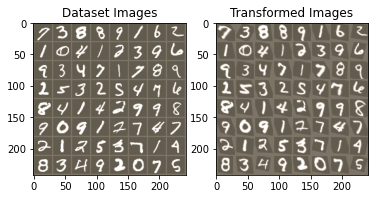

In [142]:
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

# We want to visualize the output of the spatial transformers layer
# after the training, we visualize a batch of input images and
# the corresponding transformed batch using STN.


def visualize_stn():
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(test_loader))[0].to(device)

        input_tensor = data.cpu()
        transformed_input_tensor = model.stn(data).cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')

for epoch in range(1, 20 + 1):
    train(epoch)
    test()

# Visualize the STN transformation on some input batch
visualize_stn()

plt.ioff()
plt.show()

### References:

[1] Jaderberg, Max, Karen Simonyan, and Andrew Zisserman. "Spatial transformer networks." Advances in neural information processing systems 28 (2015).